# Binary Classification Model for Chronic Kidney Disease Using Python
### David Lowe
### November 7, 2019

Template Credit: Adapted from a template made available by Dr. Jason Brownlee of Machine Learning Mastery. [https://machinelearningmastery.com/]

SUMMARY: The purpose of this project is to construct a predictive model using various machine learning algorithms and to document the end-to-end steps using a template. The Chronic Kidney Disease dataset is a binary classification situation where we are trying to predict one of the two possible outcomes.

INTRODUCTION: The problem is to predict the chronic kidney disease from the dataset that was collected from the hospital records for two months.

ANALYSIS: The baseline performance of the machine learning algorithms achieved an average accuracy of 97.61%. Two algorithms (Logistic Regression and Extra Trees) achieved the top accuracy metrics after the first round of modeling. After tuning the hyperparameters, Logistic Regression turned in the top overall result and achieved an accuracy metric of 99.33% with the training dataset. Using the same hyperparameters, the Logistic Regression algorithm processed the test dataset with an accuracy of 100%, which was even better than the prediction from the training data.

CONCLUSION: For this iteration, the Logistic Regression algorithm achieved the best overall results using the training and test datasets. For this dataset, Extra Trees should be considered for further modeling.

Dataset Used: Chronic Kidney Disease Data Set

Dataset ML Model: Binary classification with numerical and categorical attributes

Dataset Reference: https://archive.ics.uci.edu/ml/datasets/chronic_kidney_disease

One potential source of performance benchmark: https://www.kaggle.com/mansoordaku/ckdisease

The project aims to touch on the following areas:

* Document a predictive modeling problem end-to-end.
* Explore data cleaning and transformation options
* Explore non-ensemble and ensemble algorithms for baseline model performance
* Explore algorithm tuning techniques for improving model performance

Any predictive modeling machine learning project genrally can be broken down into about six major tasks:

1. Prepare Environment
2. Summarize Data
3. Prepare Data
4. Model and Evaluate Algorithms
5. Improve Accuracy or Results
6. Finalize Model and Present Results

## Section 1 - Prepare Environment

### 1.a) Load libraries and modules

In [1]:
# Set the warning message filter
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [2]:
# Set the random seed number for reproducible results
seedNum = 888

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import os
import sys
import shutil
import urllib.request
import zipfile
import smtplib
import re
from datetime import datetime
from email.message import EmailMessage
from pandas.plotting import scatter_matrix
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from imblearn.combine import SMOTETomek

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.ensemble import RUSBoostClassifier
from imblearn.ensemble import BalancedBaggingClassifier
from xgboost import XGBClassifier

Using TensorFlow backend.


### 1.b) Set up the controlling parameters and functions

In [4]:
# Begin the timer for the script processing
startTimeScript = datetime.now()

# Set up the number of CPU cores available for multi-thread processing
n_jobs = -1

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
notifyStatus = False

# Set the flag for splitting the dataset
splitDataset = True
splitPercentage = 0.25

# Set the number of folds for cross validation
n_folds = 10

# Set various default modeling parameters
scoring = 'accuracy'
# scoring = 'roc_auc'

In [5]:
# Set up the email notification function
def email_notify(msg_text):
    sender = os.environ.get('MAIL_SENDER')
    receiver = os.environ.get('MAIL_RECEIVER')
    gateway = os.environ.get('SMTP_GATEWAY')
    smtpuser = os.environ.get('SMTP_USERNAME')
    password = os.environ.get('SMTP_PASSWORD')
    if sender==None or receiver==None or gateway==None or smtpuser==None or password==None:
        sys.exit("Incomplete email setup info. Script Processing Aborted!!!")
    msg = EmailMessage()
    msg.set_content(msg_text)
    msg['Subject'] = 'Notification from Python Binary Classification Script'
    msg['From'] = sender
    msg['To'] = receiver
    server = smtplib.SMTP(gateway, 587)
    server.starttls()
    server.login(smtpuser, password)
    server.send_message(msg)
    server.quit()

In [6]:
if (notifyStatus): email_notify("Library and Data Loading has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 1.c) Load dataset

In [7]:
dataset_path = 'https://raw.githubusercontent.com/daines-analytics/datasets-public/master/chronic-kidney-disease/chronic_kidney_disease.arff'
colNames = ['age', 'bp', 'sg', 'al', 'su', 'rbc', 'pc', 'pcc', 'ba', 'bgr', 'bu', 'sc', 'sod', 'pot',
            'hemo', 'pcv', 'wbcc', 'rbcc', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane', 'class']
Xy_original = pd.read_csv(dataset_path, names=colNames, sep=',', header=None, index_col=False, skiprows= 29, na_values=['?'], skipinitialspace=True)

# Take a peek at the dataframe after import
Xy_original.head(10)

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class
0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,121.0,...,44.0,7800.0,5.2,yes,yes,no,good,no,no,ckd
1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,NaN,...,38.0,6000.0,NaN,no,no,no,good,no,no,ckd
2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,423.0,...,31.0,7500.0,NaN,no,yes,no,poor,no,yes,ckd
3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,117.0,...,32.0,6700.0,3.9,yes,no,no,poor,yes,yes,ckd
4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,106.0,...,35.0,7300.0,4.6,no,no,no,good,no,no,ckd
5,60.0,90.0,1.015,3.0,0.0,NaN,NaN,notpresent,notpresent,74.0,...,39.0,7800.0,4.4,yes,yes,no,good,yes,no,ckd
6,68.0,70.0,1.010,0.0,0.0,NaN,normal,notpresent,notpresent,100.0,...,36.0,NaN,NaN,no,no,no,good,no,no,ckd
7,24.0,NaN,1.015,2.0,4.0,normal,abnormal,notpresent,notpresent,410.0,...,44.0,6900.0,5.0,no,yes,no,good,yes,no,ckd
8,52.0,100.0,1.015,3.0,0.0,normal,abnormal,present,notpresent,138.0,...,33.0,9600.0,4.0,yes,yes,no,good,no,yes,ckd
9,53.0,90.0,1.020,2.0,0.0,abnormal,abnormal,present,notpresent,70.0,...,29.0,12100.0,3.7,yes,yes,no,poor,no,yes,ckd


In [8]:
Xy_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 25 columns):
age      391 non-null float64
bp       388 non-null float64
sg       353 non-null float64
al       354 non-null float64
su       351 non-null float64
rbc      248 non-null object
pc       335 non-null object
pcc      396 non-null object
ba       396 non-null object
bgr      356 non-null float64
bu       381 non-null float64
sc       383 non-null float64
sod      313 non-null float64
pot      312 non-null float64
hemo     348 non-null float64
pcv      329 non-null float64
wbcc     294 non-null float64
rbcc     269 non-null float64
htn      398 non-null object
dm       397 non-null object
cad      398 non-null object
appet    399 non-null object
pe       399 non-null object
ane      399 non-null object
class    400 non-null object
dtypes: float64(14), object(11)
memory usage: 78.2+ KB


In [9]:
Xy_original.describe()

,age,bp,sg,al,su,bgr,bu,sc,sod,pot,hemo,pcv,wbcc,rbcc
count,391.000000,388.000000,353.000000,354.000000,351.000000,356.000000,381.000000,383.000000,313.000000,312.000000,348.000000,329.000000,294.000000,269.000000
mean,51.483376,76.469072,1.017408,1.016949,0.450142,148.036517,57.425722,3.072454,137.528754,4.627244,12.526437,38.884498,8406.122449,4.707435
std,17.169714,13.683637,0.005717,1.352679,1.099191,79.281714,50.503006,5.741126,10.408752,3.193904,2.912587,8.990105,2944.474190,1.025323
min,2.000000,50.000000,1.005000,0.000000,0.000000,22.000000,1.500000,0.400000,4.500000,2.500000,3.100000,9.000000,2200.000000,2.100000
25%,42.000000,70.000000,1.010000,0.000000,0.000000,99.000000,27.000000,0.900000,135.000000,3.800000,10.300000,32.000000,6500.000000,3.900000
50%,55.000000,80.000000,1.020000,0.000000,0.000000,121.000000,42.000000,1.300000,138.000000,4.400000,12.650000,40.000000,8000.000000,4.800000
75%,64.500000,80.000000,1.020000,2.000000,0.000000,163.000000,66.000000,2.800000,142.000000,4.900000,15.000000,45.000000,9800.000000,5.400000
max,90.000000,180.000000,1.025000,5.000000,5.000000,490.000000,391.000000,76.000000,163.000000,47.000000,17.800000,54.000000,26400.000000,8.000000


In [10]:
print(Xy_original.isnull().sum())
print('Total number of NaN in the dataframe: ', Xy_original.isnull().sum().sum())

age        9
bp        12
sg        47
al        46
su        49
rbc      152
pc        65
pcc        4
ba         4
bgr       44
bu        19
sc        17
sod       87
pot       88
hemo      52
pcv       71
wbcc     106
rbcc     131
htn        2
dm         3
cad        2
appet      1
pe         1
ane        1
class      0
dtype: int64
Total number of NaN in the dataframe:  1013


### 1.d) Data Cleaning

In [11]:
# Impute missing values
Xy_original['age'].fillna(value=Xy_original['age'].median(), inplace=True)
Xy_original['bp'].fillna(value=Xy_original['bp'].median(), inplace=True)
Xy_original['sg'].fillna(1.015, inplace=True)
Xy_original['sg'] = Xy_original['sg'].astype('category')
Xy_original['al'].fillna(2.5, inplace=True)
Xy_original['al'] = Xy_original['al'].astype('category')
Xy_original['su'].fillna(2.5, inplace=True)
Xy_original['su'] = Xy_original['su'].astype('category')
Xy_original['rbc'].fillna('unknown', inplace=True)
Xy_original['rbc'] = Xy_original['rbc'].astype('category')
Xy_original['pc'].fillna('unknown', inplace=True)
Xy_original['pc'] = Xy_original['pc'].astype('category')
Xy_original['pcc'].fillna('unknown', inplace=True)
Xy_original['pcc'] = Xy_original['pcc'].astype('category')
Xy_original['ba'].fillna('unknown', inplace=True)
Xy_original['ba'] = Xy_original['ba'].astype('category')
Xy_original['bgr'].fillna(value=Xy_original['bgr'].median(), inplace=True)
Xy_original['bu'].fillna(value=Xy_original['bu'].median(), inplace=True)
Xy_original['sc'].fillna(value=Xy_original['sc'].median(), inplace=True)
Xy_original['sod'].fillna(value=Xy_original['sod'].median(), inplace=True)
Xy_original['pot'].fillna(value=Xy_original['pot'].median(), inplace=True)
Xy_original['hemo'].fillna(value=Xy_original['hemo'].median(), inplace=True)
Xy_original['pcv'].fillna(value=Xy_original['pcv'].median(), inplace=True)
Xy_original['wbcc'].fillna(value=Xy_original['wbcc'].median(), inplace=True)
Xy_original['rbcc'].fillna(value=Xy_original['rbcc'].median(), inplace=True)
Xy_original['htn'].fillna('unknown', inplace=True)
Xy_original['htn'] = Xy_original['htn'].astype('category')
Xy_original['dm'].fillna('unknown', inplace=True)
Xy_original['dm'] = Xy_original['dm'].astype('category')
Xy_original['cad'].fillna('unknown', inplace=True)
Xy_original['cad'] = Xy_original['cad'].astype('category')
Xy_original['appet'].fillna('unknown', inplace=True)
Xy_original['appet'] = Xy_original['appet'].astype('category')
Xy_original['pe'].fillna('unknown', inplace=True)
Xy_original['pe'] = Xy_original['pe'].astype('category')
Xy_original['ane'].fillna('unknown', inplace=True)
Xy_original['ane'] = Xy_original['ane'].astype('category')

# Convert the class feature with ckd/notckd levels into categorical feature of 0/1
def reClassSomecol(target):
    if (target == 'ckd'): return 1
    else: return 0
Xy_original['targetVar'] = Xy_original['class'].apply(reClassSomecol)
Xy_original.drop(columns=['class'], inplace=True)

# Take a peek at the dataframe after cleaning
Xy_original.head(10)

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,targetVar
0,48.0,80.0,1.020,1.0,0.0,unknown,normal,notpresent,notpresent,121.0,...,44.0,7800.0,5.2,yes,yes,no,good,no,no,1
1,7.0,50.0,1.020,4.0,0.0,unknown,normal,notpresent,notpresent,121.0,...,38.0,6000.0,4.8,no,no,no,good,no,no,1
2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,423.0,...,31.0,7500.0,4.8,no,yes,no,poor,no,yes,1
3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,117.0,...,32.0,6700.0,3.9,yes,no,no,poor,yes,yes,1
4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,106.0,...,35.0,7300.0,4.6,no,no,no,good,no,no,1
5,60.0,90.0,1.015,3.0,0.0,unknown,unknown,notpresent,notpresent,74.0,...,39.0,7800.0,4.4,yes,yes,no,good,yes,no,1
6,68.0,70.0,1.010,0.0,0.0,unknown,normal,notpresent,notpresent,100.0,...,36.0,8000.0,4.8,no,no,no,good,no,no,1
7,24.0,80.0,1.015,2.0,4.0,normal,abnormal,notpresent,notpresent,410.0,...,44.0,6900.0,5.0,no,yes,no,good,yes,no,1
8,52.0,100.0,1.015,3.0,0.0,normal,abnormal,present,notpresent,138.0,...,33.0,9600.0,4.0,yes,yes,no,good,no,yes,1
9,53.0,90.0,1.020,2.0,0.0,abnormal,abnormal,present,notpresent,70.0,...,29.0,12100.0,3.7,yes,yes,no,poor,no,yes,1


In [12]:
Xy_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 25 columns):
age          400 non-null float64
bp           400 non-null float64
sg           400 non-null category
al           400 non-null category
su           400 non-null category
rbc          400 non-null category
pc           400 non-null category
pcc          400 non-null category
ba           400 non-null category
bgr          400 non-null float64
bu           400 non-null float64
sc           400 non-null float64
sod          400 non-null float64
pot          400 non-null float64
hemo         400 non-null float64
pcv          400 non-null float64
wbcc         400 non-null float64
rbcc         400 non-null float64
htn          400 non-null category
dm           400 non-null category
cad          400 non-null category
appet        400 non-null category
pe           400 non-null category
ane          400 non-null category
targetVar    400 non-null int64
dtypes: category(13), float64(11),

In [13]:
Xy_original.describe()

,age,bp,bgr,bu,sc,sod,pot,hemo,pcv,wbcc,rbcc,targetVar
count,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.00000,400.000000,400.000000,400.000000,400.000000
mean,51.562500,76.575000,145.062500,56.693000,2.997125,137.631250,4.577250,12.54250,39.082500,8298.500000,4.737750,0.625000
std,16.982996,13.489785,75.260774,49.395258,5.628886,9.206332,2.821357,2.71649,8.162245,2529.593814,0.841439,0.484729
min,2.000000,50.000000,22.000000,1.500000,0.400000,4.500000,2.500000,3.10000,9.000000,2200.000000,2.100000,0.000000
25%,42.000000,70.000000,101.000000,27.000000,0.900000,135.000000,4.000000,10.87500,34.000000,6975.000000,4.500000,0.000000
50%,55.000000,80.000000,121.000000,42.000000,1.300000,138.000000,4.400000,12.65000,40.000000,8000.000000,4.800000,1.000000
75%,64.000000,80.000000,150.000000,61.750000,2.725000,141.000000,4.800000,14.62500,44.000000,9400.000000,5.100000,1.000000
max,90.000000,180.000000,490.000000,391.000000,76.000000,163.000000,47.000000,17.80000,54.000000,26400.000000,8.000000,1.000000


In [14]:
print(Xy_original.isnull().sum())
print('Total number of NaN in the dataframe: ', Xy_original.isnull().sum().sum())

age          0
bp           0
sg           0
al           0
su           0
rbc          0
pc           0
pcc          0
ba           0
bgr          0
bu           0
sc           0
sod          0
pot          0
hemo         0
pcv          0
wbcc         0
rbcc         0
htn          0
dm           0
cad          0
appet        0
pe           0
ane          0
targetVar    0
dtype: int64
Total number of NaN in the dataframe:  0


### 1.e) Splitting Data into Attribute-only and Target-only Sets

In [15]:
# Use variable totCol to hold the number of columns in the dataframe
totCol = len(Xy_original.columns)

# Set up variable totAttr for the total number of attribute columns
totAttr = totCol-1

# targetCol variable indicates the column location of the target/class variable
# If the first column, set targetCol to 1. If the last column, set targetCol to totCol
# If (targetCol <> 1) and (targetCol <> totCol), be aware when slicing up the dataframes for visualization
targetCol = totCol

In [16]:
# We create attribute-only and target-only datasets (X_original and y_original)
# for various visualization and cleaning/transformation operations

if targetCol == totCol:
    X_original = Xy_original.iloc[:,0:totAttr]
    y_original = Xy_original.iloc[:,totAttr]
else:
    X_original = Xy_original.iloc[:,1:totCol]
    y_original = Xy_original.iloc[:,0]

print("Xy_original.shape: {} X_original.shape: {} y_original.shape: {}".format(Xy_original.shape, X_original.shape, y_original.shape))

Xy_original.shape: (400, 25) X_original.shape: (400, 24) y_original.shape: (400,)


### 1.f) Set up the parameters for data visualization

In [17]:
# Set up the number of row and columns for visualization display. dispRow * dispCol should be >= totAttr
dispCol = 4
if totAttr % dispCol == 0 :
    dispRow = totAttr // dispCol
else :
    dispRow = (totAttr // dispCol) + 1
    
# Set figure width to display the data visualization plots
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = dispCol*4
fig_size[1] = dispRow*4
plt.rcParams["figure.figsize"] = fig_size

In [18]:
if (notifyStatus): email_notify("Library and Data Loading completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Section 2 - Summarize Data
To gain a better understanding of the data that we have on-hand, we will leverage a number of descriptive statistics and data visualization techniques. The plan is to use the results to consider new questions, review assumptions, and validate hypotheses that we can investigate later with specialized models.

In [19]:
if (notifyStatus): email_notify("Data Summarization and Visualization has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 2.a) Descriptive Statistics

#### 2.a.i) Peek at the attribute columns

In [20]:
X_original.head(10)

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,hemo,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane
0,48.0,80.0,1.020,1.0,0.0,unknown,normal,notpresent,notpresent,121.0,...,15.4,44.0,7800.0,5.2,yes,yes,no,good,no,no
1,7.0,50.0,1.020,4.0,0.0,unknown,normal,notpresent,notpresent,121.0,...,11.3,38.0,6000.0,4.8,no,no,no,good,no,no
2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,423.0,...,9.6,31.0,7500.0,4.8,no,yes,no,poor,no,yes
3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,117.0,...,11.2,32.0,6700.0,3.9,yes,no,no,poor,yes,yes
4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,106.0,...,11.6,35.0,7300.0,4.6,no,no,no,good,no,no
5,60.0,90.0,1.015,3.0,0.0,unknown,unknown,notpresent,notpresent,74.0,...,12.2,39.0,7800.0,4.4,yes,yes,no,good,yes,no
6,68.0,70.0,1.010,0.0,0.0,unknown,normal,notpresent,notpresent,100.0,...,12.4,36.0,8000.0,4.8,no,no,no,good,no,no
7,24.0,80.0,1.015,2.0,4.0,normal,abnormal,notpresent,notpresent,410.0,...,12.4,44.0,6900.0,5.0,no,yes,no,good,yes,no
8,52.0,100.0,1.015,3.0,0.0,normal,abnormal,present,notpresent,138.0,...,10.8,33.0,9600.0,4.0,yes,yes,no,good,no,yes
9,53.0,90.0,1.020,2.0,0.0,abnormal,abnormal,present,notpresent,70.0,...,9.5,29.0,12100.0,3.7,yes,yes,no,poor,no,yes


#### 2.a.ii) Dimensions and attribute types

In [21]:
X_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 24 columns):
age      400 non-null float64
bp       400 non-null float64
sg       400 non-null category
al       400 non-null category
su       400 non-null category
rbc      400 non-null category
pc       400 non-null category
pcc      400 non-null category
ba       400 non-null category
bgr      400 non-null float64
bu       400 non-null float64
sc       400 non-null float64
sod      400 non-null float64
pot      400 non-null float64
hemo     400 non-null float64
pcv      400 non-null float64
wbcc     400 non-null float64
rbcc     400 non-null float64
htn      400 non-null category
dm       400 non-null category
cad      400 non-null category
appet    400 non-null category
pe       400 non-null category
ane      400 non-null category
dtypes: category(13), float64(11)
memory usage: 41.7 KB


#### 2.a.iii) Statistical summary of the attributes

In [22]:
X_original.describe()

,age,bp,bgr,bu,sc,sod,pot,hemo,pcv,wbcc,rbcc
count,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.00000,400.000000,400.000000,400.000000
mean,51.562500,76.575000,145.062500,56.693000,2.997125,137.631250,4.577250,12.54250,39.082500,8298.500000,4.737750
std,16.982996,13.489785,75.260774,49.395258,5.628886,9.206332,2.821357,2.71649,8.162245,2529.593814,0.841439
min,2.000000,50.000000,22.000000,1.500000,0.400000,4.500000,2.500000,3.10000,9.000000,2200.000000,2.100000
25%,42.000000,70.000000,101.000000,27.000000,0.900000,135.000000,4.000000,10.87500,34.000000,6975.000000,4.500000
50%,55.000000,80.000000,121.000000,42.000000,1.300000,138.000000,4.400000,12.65000,40.000000,8000.000000,4.800000
75%,64.000000,80.000000,150.000000,61.750000,2.725000,141.000000,4.800000,14.62500,44.000000,9400.000000,5.100000
max,90.000000,180.000000,490.000000,391.000000,76.000000,163.000000,47.000000,17.80000,54.000000,26400.000000,8.000000


#### 2.a.iv) Summarize the levels of the class attribute

In [23]:
Xy_original.groupby('targetVar').size()

targetVar
0    150
1    250
dtype: int64

### 2.b) Data Visualization

##### 2.b.i) Univariate plots to better understand each attribute

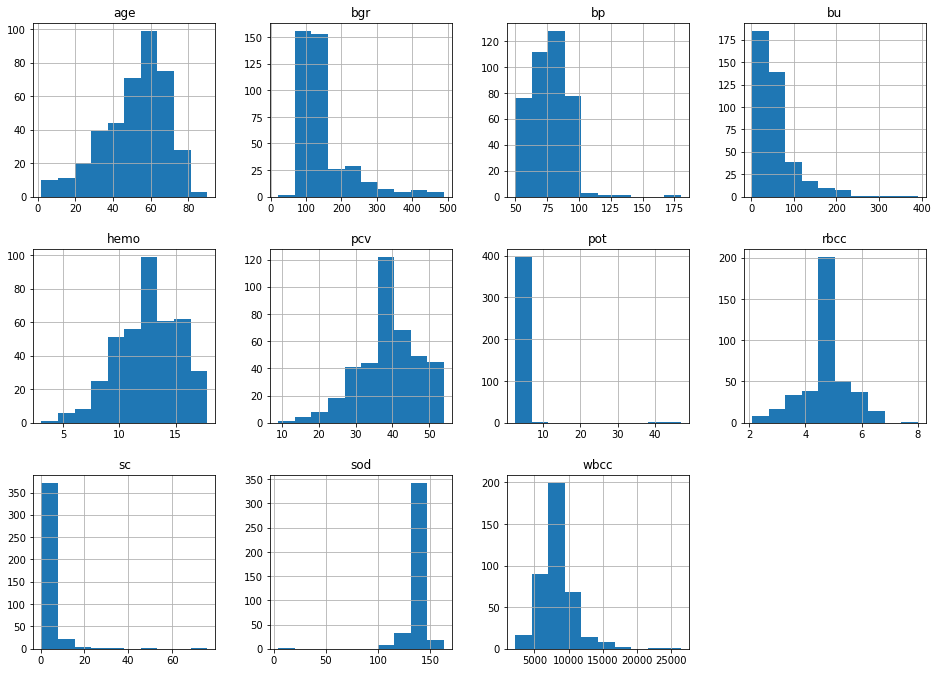

In [24]:
# Histograms for each attribute
X_original.hist(layout=(dispRow,dispCol))
plt.show()

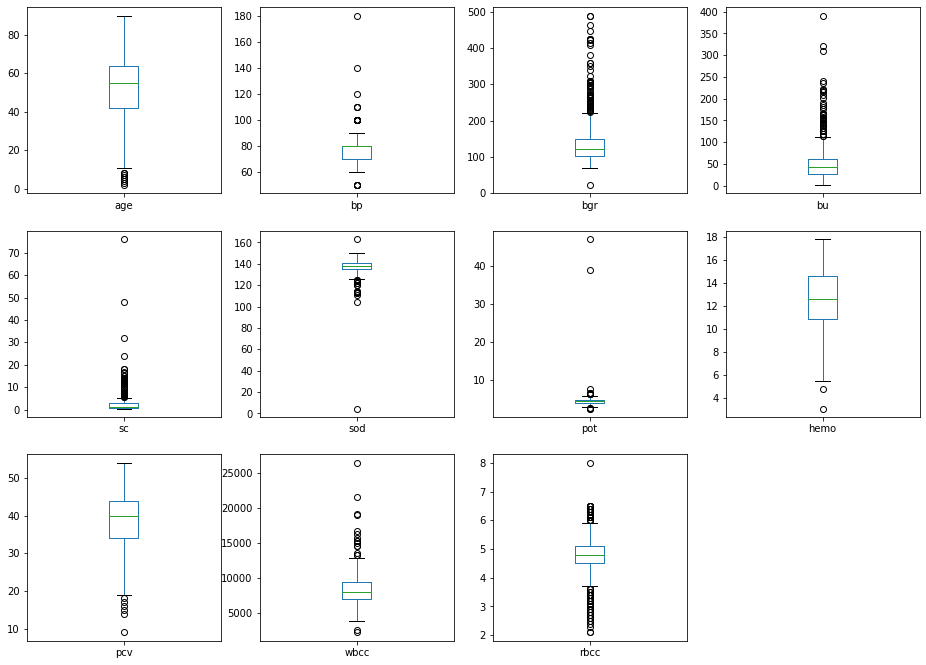

In [25]:
# Box and Whisker plot for each attribute
X_original.plot(kind='box', subplots=True, layout=(dispRow,dispCol))
plt.show()

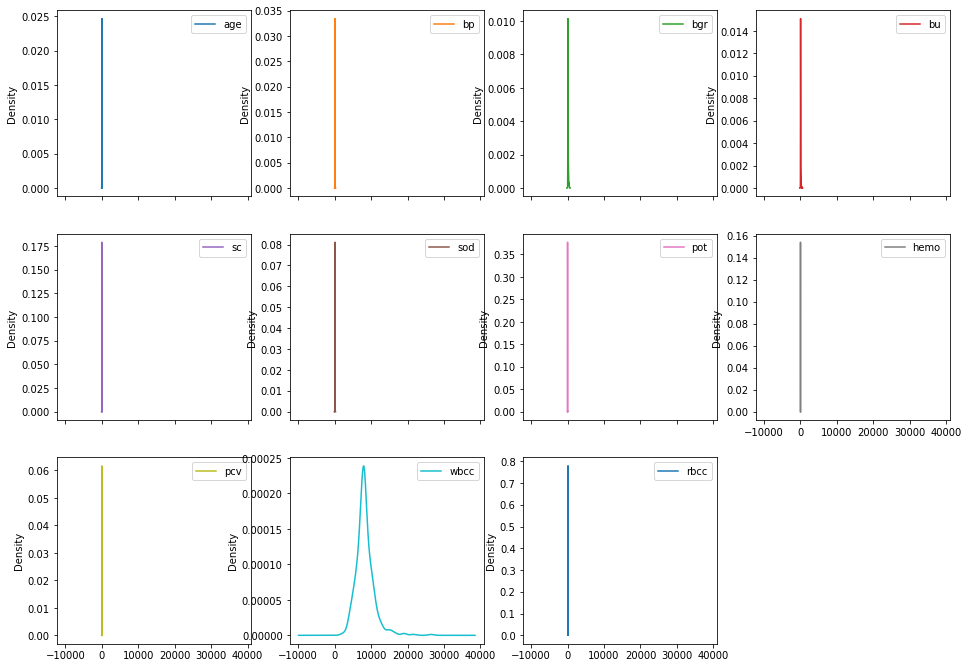

In [26]:
# Density plot for each attribute
X_original.plot(kind='density', subplots=True, layout=(dispRow,dispCol))
plt.show()

#### 2.b.ii) Multivariate plots to better understand the relationships between attributes

In [27]:
# Scatterplot matrix
# scatter_matrix(X_original)
# plt.show()

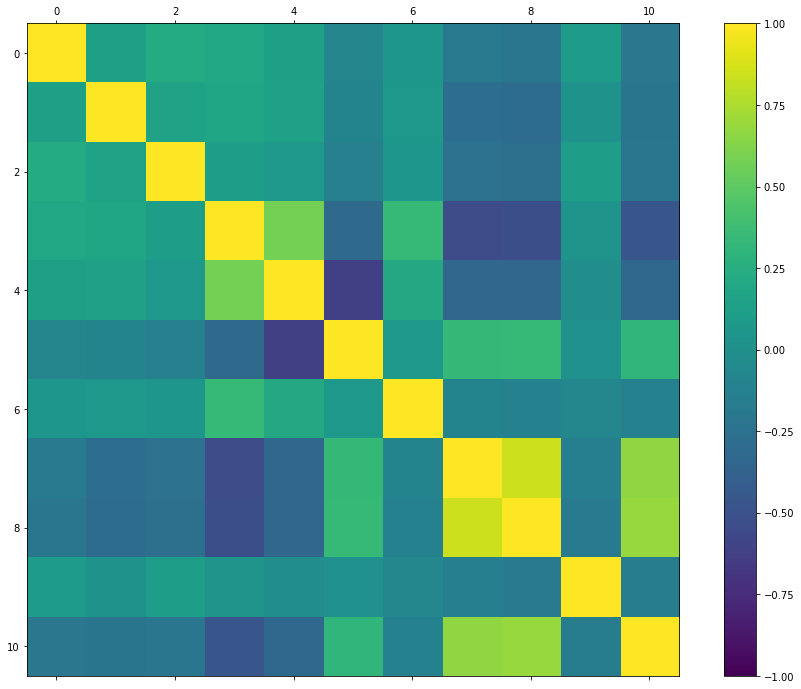

In [28]:
# Correlation matrix
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(111)
correlations = X_original.corr(method='pearson')
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
plt.show()

In [29]:
if (notifyStatus): email_notify("Data Summarization and Visualization completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Section 3 - Prepare Data
Some dataset may require additional preparation activities that will best exposes the structure of the problem and the relationships between the input attributes and the output variable. Some data-prep tasks might include:

* Cleaning data by removing duplicates, marking missing values and even imputing missing values.
* Feature selection where redundant features may be removed.
* Data transforms where attributes are scaled or redistributed in order to best expose the structure of the problem later to learning algorithms.

In [30]:
if (notifyStatus): email_notify("Data Cleaning and Transformation has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 3.a) Feature Scaling and Data Pre-Processing

In [31]:
# Apply feature scaling techniques
X_original['age'] = preprocessing.scale(X_original['age'])
X_original['bp'] = preprocessing.scale(X_original['bp'])
X_original['bgr'] = preprocessing.scale(X_original['bgr'])
X_original['bu'] = preprocessing.scale(X_original['bu'])
X_original['sc'] = preprocessing.scale(X_original['sc'])
X_original['sod'] = preprocessing.scale(X_original['sod'])
X_original['pot'] = preprocessing.scale(X_original['pot'])
X_original['hemo'] = preprocessing.scale(X_original['hemo'])
X_original['pcv'] = preprocessing.scale(X_original['pcv'])
X_original['wbcc'] = preprocessing.scale(X_original['wbcc'])
X_original['rbcc'] = preprocessing.scale(X_original['rbcc'])

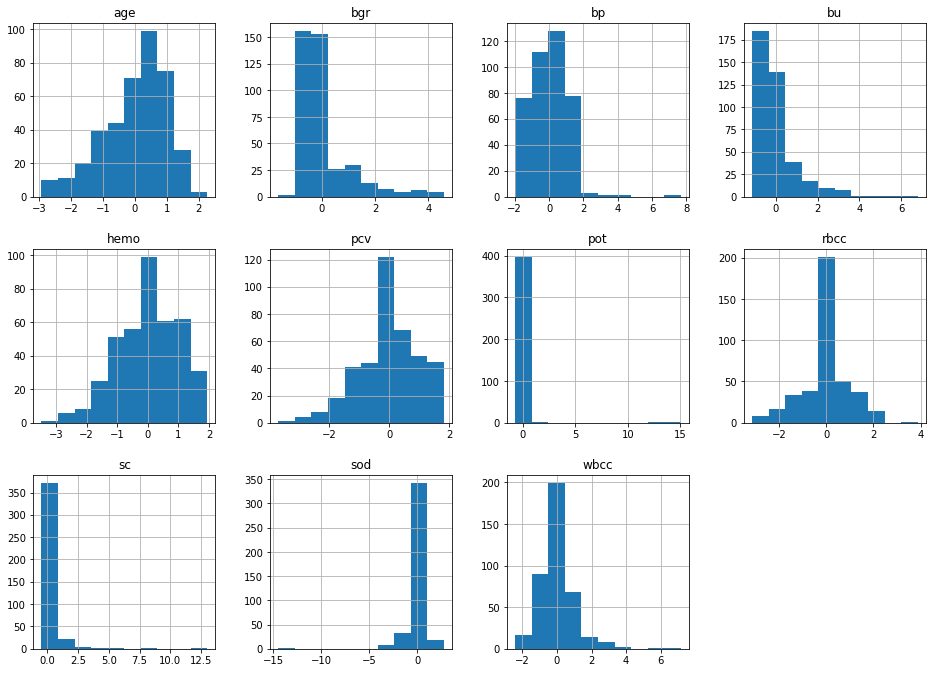

In [32]:
# Histograms for each attribute
X_original.hist(layout=(dispRow,dispCol))
plt.show()

In [33]:
# Perform one-hot-encoding before splitting into trainig and test
X_original = pd.get_dummies(X_original)
print(X_original.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 62 columns):
age               400 non-null float64
bp                400 non-null float64
bgr               400 non-null float64
bu                400 non-null float64
sc                400 non-null float64
sod               400 non-null float64
pot               400 non-null float64
hemo              400 non-null float64
pcv               400 non-null float64
wbcc              400 non-null float64
rbcc              400 non-null float64
sg_1.005          400 non-null uint8
sg_1.01           400 non-null uint8
sg_1.015          400 non-null uint8
sg_1.02           400 non-null uint8
sg_1.025          400 non-null uint8
al_0.0            400 non-null uint8
al_1.0            400 non-null uint8
al_2.0            400 non-null uint8
al_2.5            400 non-null uint8
al_3.0            400 non-null uint8
al_4.0            400 non-null uint8
al_5.0            400 non-null uint8
su_0.0            400 

### 3.b) Splitting Data into Training and Test Sets

In [34]:
# Split the data further into training and test datasets
if (splitDataset):
    X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(X_original, y_original, test_size=splitPercentage, 
                                                                    stratify=y_original, random_state=seedNum)
else:
    X_train_df, y_train_df = X_original, y_original
    X_test_df, y_test_df = X_original, y_original
print("X_train_df.shape: {} y_train_df.shape: {}".format(X_train_df.shape, y_train_df.shape))
print("X_test_df.shape: {} y_test_df.shape: {}".format(X_test_df.shape, y_test_df.shape))

X_train_df.shape: (300, 62) y_train_df.shape: (300,)
X_test_df.shape: (100, 62) y_test_df.shape: (100,)


### 3.c) Feature Selection

In [35]:
# Not applicable for this iteration of the project

### 3.d) Display the Final Datasets for Model-Building

In [36]:
# Finalize the training and testing datasets for the modeling activities
X_train = X_train_df.to_numpy()
y_train = y_train_df.to_numpy()
X_test = X_test_df.to_numpy()
y_test = y_test_df.to_numpy()
print("X_train.shape: {} y_train.shape: {}".format(X_train.shape, y_train.shape))
print("X_test.shape: {} y_test.shape: {}".format(X_test.shape, y_test.shape))

X_train.shape: (300, 62) y_train.shape: (300,)
X_test.shape: (100, 62) y_test.shape: (100,)


In [37]:
if (notifyStatus): email_notify("Data Cleaning and Transformation completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## 4. Model and Evaluate Algorithms
After the data-prep, we next work on finding a workable model by evaluating a subset of machine learning algorithms that are good at exploiting the structure of the training. The typical evaluation tasks include:

* Defining test options such as cross validation and the evaluation metric to use.
* Spot checking a suite of linear and nonlinear machine learning algorithms.
* Comparing the estimated accuracy of algorithms.

For this project, we will evaluate one linear, two non-linear and four ensemble algorithms:

Linear Algorithm: Logistic Regression

Non-Linear Algorithms: Decision Trees (CART) and k-Nearest Neighbors

Ensemble Algorithms: Bagged CART, Random Forest, Extra Trees, and Gradient Boosting

The random number seed is reset before each run to ensure that the evaluation of each algorithm is performed using the same data splits. It ensures the results are directly comparable.

### 4.a) Set test options and evaluation metric

In [38]:
# Set up Algorithms Spot-Checking Array
startTimeModule = datetime.now()
train_models = []
train_results = []
train_model_names = []
train_metrics = []
train_models.append(('LR', LogisticRegression(random_state=seedNum)))
train_models.append(('CART', DecisionTreeClassifier(random_state=seedNum)))
train_models.append(('KNN', KNeighborsClassifier(n_jobs=n_jobs)))
train_models.append(('BT', BaggingClassifier(random_state=seedNum, n_jobs=n_jobs)))
train_models.append(('RF', RandomForestClassifier(random_state=seedNum, n_jobs=n_jobs)))
train_models.append(('ET', ExtraTreesClassifier(random_state=seedNum, n_jobs=n_jobs)))
train_models.append(('GBM', GradientBoostingClassifier(random_state=seedNum)))
# models.append(('XGB', XGBClassifier(random_state=seedNum, n_jobs=n_jobs)))

In [39]:
# Generate model in turn
for name, model in train_models:
	if (notifyStatus): email_notify("Algorithm "+name+" modeling has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
	startTimeModule = datetime.now()
	kfold = KFold(n_splits=n_folds, random_state=seedNum)
	cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
	train_results.append(cv_results)
	train_model_names.append(name)
	train_metrics.append(cv_results.mean())
	print("%s: %f (%f)" % (name, cv_results.mean(), cv_results.std()))
	print(model)
	print ('Model training time:', (datetime.now() - startTimeModule), '\n')
	if (notifyStatus): email_notify("Algorithm "+name+" modeling completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
print ('Average metrics ('+scoring+') from all models:',np.mean(train_metrics))
print ('Total training time for all models:',(datetime.now() - startTimeModule))

LR: 0.990000 (0.015275)
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=888, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
Model training time: 0:00:00.085796 

CART: 0.940000 (0.024944)
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=888, splitter='best')
Model training time: 0:00:00.062276 

KNN: 0.970000 (0.027689)
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=

### 4.b) Spot-checking baseline algorithms

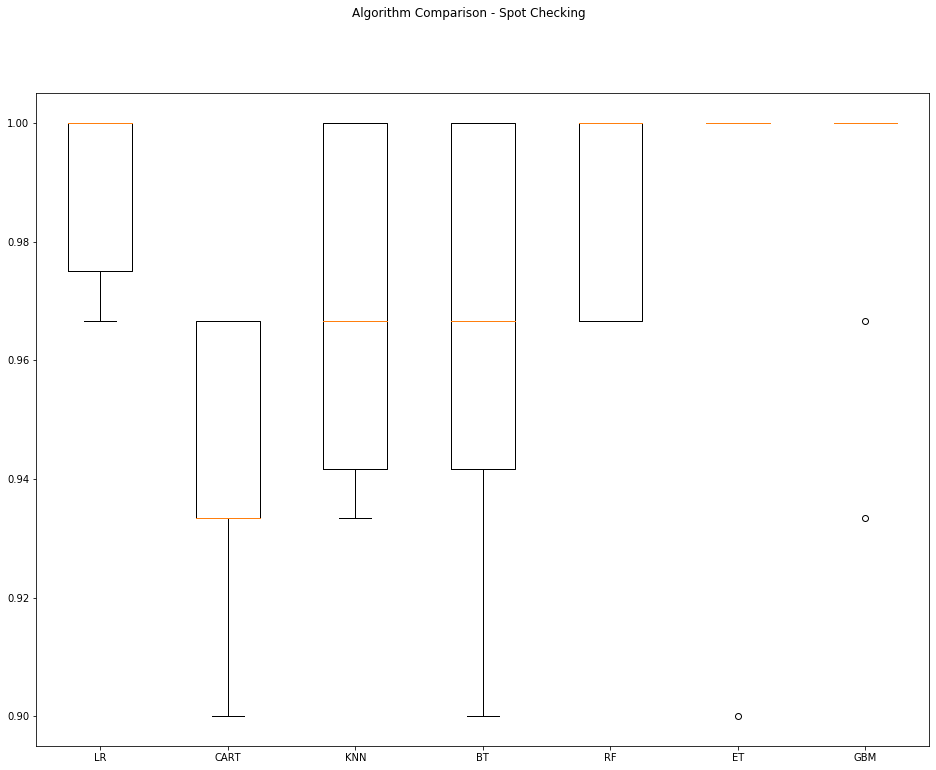

In [40]:
fig = plt.figure(figsize=(16,12))
fig.suptitle('Algorithm Comparison - Spot Checking')
ax = fig.add_subplot(111)
plt.boxplot(train_results)
ax.set_xticklabels(train_model_names)
plt.show()

## Section 5 - Improve Accuracy
After we achieve a short list of machine learning algorithms with good level of accuracy, we can leverage ways to improve the accuracy of the models.

### 5.a) Algorithm Tuning

In [41]:
# Set up the comparison array
tune_results = []
tune_model_names = []

In [42]:
# Tuning algorithm #1 - Logistic Regression
startTimeModule = datetime.now()
if (notifyStatus): email_notify("Algorithm #1 tuning has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

tune_model1 = LogisticRegression(random_state=seedNum)
tune_model_names.append('LR')
paramGrid1 = dict(C=np.array([10, 1, 0.1, 0.01, 0.001]))

kfold = KFold(n_splits=n_folds, random_state=seedNum)
grid1 = GridSearchCV(estimator=tune_model1, param_grid=paramGrid1, scoring=scoring, cv=kfold)
grid_result1 = grid1.fit(X_train, y_train)

print("Best: %f using %s" % (grid_result1.best_score_, grid_result1.best_params_))
tune_results.append(grid_result1.cv_results_['mean_test_score'])
means = grid_result1.cv_results_['mean_test_score']
stds = grid_result1.cv_results_['std_test_score']
params = grid_result1.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print ('Model training time:',(datetime.now() - startTimeModule))
if (notifyStatus): email_notify("Algorithm #1 tuning completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

Best: 0.993333 using {'C': 10.0}
0.993333 (0.013333) with: {'C': 10.0}
0.990000 (0.015275) with: {'C': 1.0}
0.986667 (0.016330) with: {'C': 0.1}
0.980000 (0.022111) with: {'C': 0.01}
0.966667 (0.025820) with: {'C': 0.001}
Model training time: 0:00:00.382581


In [43]:
for key, value in grid_result1.best_params_.items():
    best_paramKey1 = key
    best_paramValue1 = value
print("Captured the best parameter for algorithm #1:", best_paramKey1, '=', best_paramValue1)

Captured the best parameter for algorithm #1: C = 10.0


In [44]:
# Tuning algorithm #2 - Extra Trees
startTimeModule = datetime.now()
if (notifyStatus): email_notify("Algorithm #2 tuning has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

tune_model2 = ExtraTreesClassifier(random_state=seedNum, n_jobs=n_jobs)
tune_model_names.append('ET')
paramGrid2 = dict(n_estimators=np.array([50, 75, 100, 125, 150]))

kfold = KFold(n_splits=n_folds, random_state=seedNum)
grid2 = GridSearchCV(estimator=tune_model2, param_grid=paramGrid2, scoring=scoring, cv=kfold)
grid_result2 = grid2.fit(X_train, y_train)

print("Best: %f using %s" % (grid_result2.best_score_, grid_result2.best_params_))
tune_results.append(grid_result2.cv_results_['mean_test_score'])
means = grid_result2.cv_results_['mean_test_score']
stds = grid_result2.cv_results_['std_test_score']
params = grid_result2.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print ('Model training time:',(datetime.now() - startTimeModule))
if (notifyStatus): email_notify("Algorithm #2 tuning completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

Best: 1.000000 using {'n_estimators': 125}
0.993333 (0.013333) with: {'n_estimators': 50}
0.996667 (0.010000) with: {'n_estimators': 75}
0.993333 (0.013333) with: {'n_estimators': 100}
1.000000 (0.000000) with: {'n_estimators': 125}
1.000000 (0.000000) with: {'n_estimators': 150}
Model training time: 0:03:05.848147


In [45]:
for key, value in grid_result2.best_params_.items():
    best_paramKey2 = key
    best_paramValue2 = value
print("Captured the best parameter for algorithm #2:", best_paramKey2, '=', best_paramValue2)

Captured the best parameter for algorithm #2: n_estimators = 125


### 5.b) Compare Algorithms After Tuning

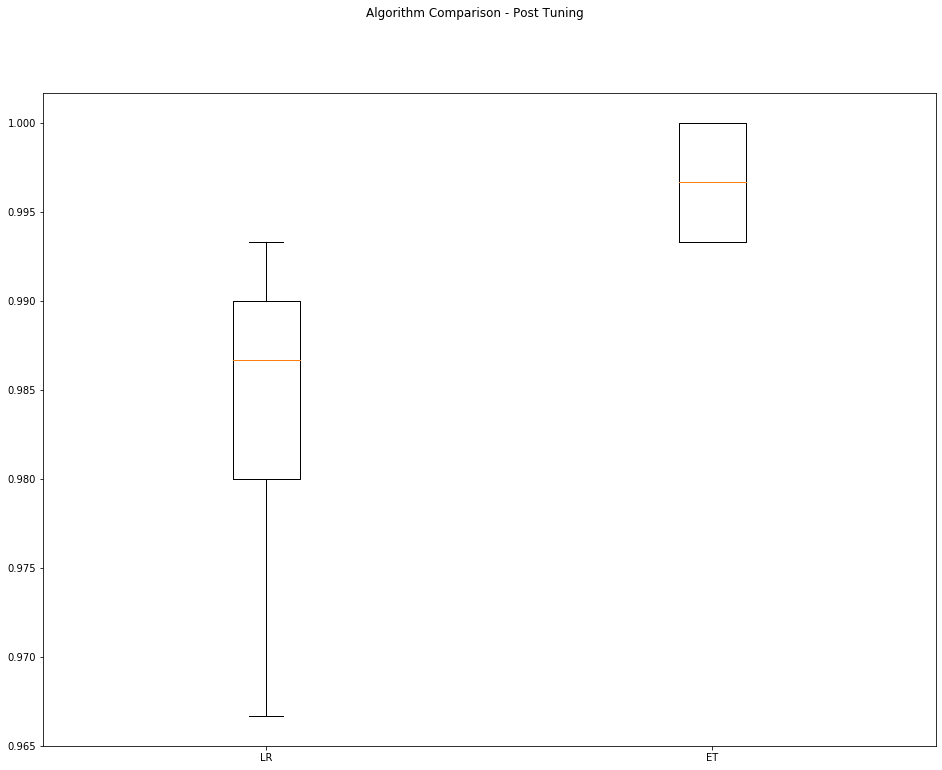

In [46]:
fig = plt.figure(figsize=(16,12))
fig.suptitle('Algorithm Comparison - Post Tuning')
ax = fig.add_subplot(111)
plt.boxplot(tune_results)
ax.set_xticklabels(tune_model_names)
plt.show()

## Section 6 - Finalize Model
Once we have narrow down to a model that we believe can make accurate predictions on unseen data, we are ready to finalize it. Finalizing a model may involve sub-tasks such as:
* Using an optimal model tuned to make predictions on unseen data.
* Creating a standalone model using the tuned parameters
* Saving an optimal model to file for later use.

In [47]:
if (notifyStatus): email_notify("Model Validation and Final Model Creation has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 6.a) Measure predictions from the test dataset

In [48]:
test_model1 = LogisticRegression(C=best_paramValue1, random_state=seedNum)
test_model1.fit(X_train, y_train)
predictions1 = test_model1.predict(X_test)
print('Accuracy Score:', accuracy_score(y_test, predictions1))
print('ROC/AUC Score:', roc_auc_score(y_test, predictions1))
print(confusion_matrix(y_test, predictions1))
print(classification_report(y_test, predictions1))
print(test_model1)

Accuracy Score: 1.0
ROC/AUC Score: 1.0
[[38  0]
 [ 0 62]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        38
           1       1.00      1.00      1.00        62

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100

LogisticRegression(C=10.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=888, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)


In [49]:
test_model2 = ExtraTreesClassifier(n_estimators=best_paramValue2, random_state=seedNum, n_jobs=n_jobs)
test_model2.fit(X_train, y_train)
predictions2 = test_model2.predict(X_test)
print('Accuracy Score:', accuracy_score(y_test, predictions2))
print('ROC/AUC Score:', roc_auc_score(y_test, predictions2))
print(confusion_matrix(y_test, predictions2))
print(classification_report(y_test, predictions2))
print(test_model2)

Accuracy Score: 0.99
ROC/AUC Score: 0.986842105263158
[[37  1]
 [ 0 62]]
              precision    recall  f1-score   support

           0       1.00      0.97      0.99        38
           1       0.98      1.00      0.99        62

    accuracy                           0.99       100
   macro avg       0.99      0.99      0.99       100
weighted avg       0.99      0.99      0.99       100

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
                     max_depth=None, max_features='auto', max_leaf_nodes=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=125, n_jobs=-1,
                     oob_score=False, random_state=888, verbose=0,
                     warm_start=False)


### 6.b) Create a standalone model using all available data

In [50]:
startTimeModule = datetime.now()

# Combining the training and testing datasets to form the complete dataset that will be used for training the final model
X_complete = np.vstack((X_train, X_test))
y_complete = np.concatenate((y_train, y_test))
print("X_complete.shape: {} y_complete.shape: {}".format(X_complete.shape, y_complete.shape))

# finalModel = LogisticRegression(C=best_paramValue2, random_state=seedNum)
# finalModel.fit(X_complete, y_complete)
# print ('Model training time:',(datetime.now() - startTimeModule))

X_complete.shape: (400, 62) y_complete.shape: (400,)


### 6.c) Save the final model for later use

In [51]:
# modelName = 'finalModel_BinaryClass.sav'
# dump(finalModel, modelName)

In [52]:
if (notifyStatus): email_notify("Model Validation and Final Model Creation completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [53]:
print ('Total time for the script:',(datetime.now() - startTimeScript))

Total time for the script: 0:06:15.531845
